In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import pandas as pd
import os
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing as mp
from IPython.core.debugger import set_trace
from IPython.display import clear_output

import copy

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from umap import UMAP

import torch
from torch import nn
from torch import optim
from torch import autograd

from torch.utils.data import DataLoader

from train_utils import *
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         to_numpy, \
                         numpy_metric, \
                         cosine_sim

from input_utils import DataGenerator, make_random_affine
from mlp_model import MLP_NonlinearEncoder
from models_utils import init_weights, \
                         universal_approximator, \
                         dJ_criterion, \
                         gained_function, \
                         sigmoid, \
                         initialize_nonlinearities

from embedding_utils import ConstructUMAPGraph, UMAPLoss, UMAPDataset, umap_criterion_compatibility

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
N_CPU = mp.cpu_count()
SEED = 42
%autoreload 2

# Load data 

In [2]:
SCALER = StandardScaler()

input_parameters = {'generator': make_swiss_roll, #make_s_curve, 
                    'generator_kwargs': {'n_samples':10000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':True,
                    'scaler':SCALER, #SCALER,
                    'use_outpt_color':True} 

create_data = DataGenerator(**input_parameters)

inpt, _, color = create_data()

N_TEST = 1000

In [3]:
inpt.mean(1), inpt.std(1)

(array([-3.92574862e-17,  2.31636932e-16, -1.77635684e-17]),
 array([1., 1., 1.]))

In [4]:
inpt_train, inpt_test, color_train, color_test = train_test_split(inpt.T, 
                                                                  color, 
                                                                  random_state=42,
                                                                  test_size=N_TEST)

In [5]:
inpt_train_torch = torch.tensor(inpt_train, dtype=torch.float32).to(device)
inpt_test_torch = torch.tensor(inpt_test, dtype=torch.float32).to(device)

In [6]:
(inpt_train_torch.T@inpt_train_torch / inpt_train_torch.shape[0]).round()

tensor([[1., 0., 0.],
        [0., 1., -0.],
        [0., -0., 1.]], device='cuda:0')

In [7]:
inpt_train_torch.mean(0), inpt_train_torch.std(0)

(tensor([-0.0037, -0.0044, -0.0056], device='cuda:0'),
 tensor([1.0019, 0.9994, 0.9994], device='cuda:0'))

In [8]:
inpt_train_torch.shape, inpt_test_torch.shape

(torch.Size([9000, 3]), torch.Size([1000, 3]))

In [9]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(inpt_test, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

In [10]:
# from mpl_toolkits import mplot3d

# plt.figure(dpi=300)

# ax = plt.axes(projection='3d')

# ax.scatter3D(inpt_test[:,0], inpt_test[:,1], inpt_test[:,2], c=color_test, cmap='viridis')
# plt.show()

# PCA

In [11]:
N_CYCLES = 1
data = [create_data()  for _ in range(N_CYCLES)]
inpt_data = np.concatenate([d[0] for d in data],-1)
outpt_data = np.concatenate([d[1] for d in data],-1)

3


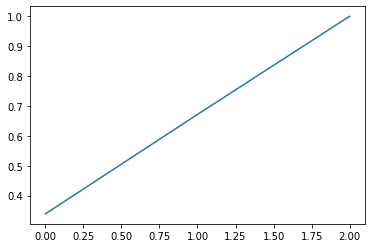

In [12]:
pca = PCA()
Z_pca = pca.fit_transform(inpt_data.T)
pca_ev = np.cumsum(pca.explained_variance_ratio_)
print((np.arange(1,inpt_data.shape[0]+1)[pca_ev > 0.99])[0])
plt.plot(pca_ev)
plt.show()

In [13]:
# plt.scatter(Z_pca[:,0], Z_pca[:,1], c=outpt_data[0])
# plt.colorbar()

In [14]:
# Z_pca_test = pca.transform(inpt_test.T)
# plt.scatter(Z_pca_test[:,0], Z_pca_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [15]:
# umap = UMAP(n_components=2, n_neighbors=50, n_jobs=1)
# Z = umap.fit_transform(inpt_data.T)
# Z_test = umap.transform(inpt_test.T)

In [16]:
# plt.scatter(Z[:,0], Z[:,1], c=outpt_data[0])
# plt.colorbar()

In [17]:
# plt.scatter(Z_test[:,0], Z_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [18]:
# Q_loc_val_UMAP, Q_glob_val_UMAP = calculate_Q_metrics(inpt_test.T, Z_test)

In [19]:
# Q_loc_val_UMAP, Q_glob_val_UMAP

# Train MLP

### Hebbian parameters

In [20]:
# encoder_parameters = {
#                     'input_dim':inpt.shape[0],
#                     'hidden_dim':10,
#                     'embedding_dim':2,
#                     'add_readout':False,
#                     'add_recurrent_connections':False,
#                     'add_recurrent_nonlinearity':False,
#                     'hebbian_update':criterion_rule,
#                     'inplace_update':False,
#                     'normalize_hebbian_update':False,
#                     'lr_hebb':1e-4,
#                     'W_requires_grad':False,
#                     'W_r_requires_grad':False,
#                     'f_requires_grad':False,
#                     'final_nonlinearity':False,
#                     'parametrized_f':False,
#                     'nonlinearity': universal_approximator,
# #                     'nonlinearity': nn.Tanh(),
#                     'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
#                     'layers_number':3,
#                     'add_bn':True,
#                     'seed':None,
#                     'set_seed':False,
#                      }

# network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

### Backprop parameters

In [21]:
encoder_parameters = {
                    'input_dim':inpt.shape[0],
                    'hidden_dim':60,
                    'embedding_dim':2,
                    'add_readout':False,
                    'add_recurrent_connections':False,
                    'add_recurrent_nonlinearity':False,
                    'hebbian_update':None,
                    'inplace_update':False,
                    'normalize_hebbian_update':False,
                    'lr_hebb':None,
                    'W_requires_grad':True,
                    'W_r_requires_grad':False,
                    'f_requires_grad':True,
                    'final_nonlinearity':False,
                    'parametrized_f':True,
                    'nonlinearity': universal_approximator,
#                     'nonlinearity': nn.Tanh(),
                    'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
                    'layers_number':4,
                    'add_bn':True,
                    'seed':None,
                    'set_seed':False,
                     }

network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

### Hebbian-Backprop parameters

In [22]:
# encoder_parameters = {
#                     'input_dim':inpt.shape[0],
#                     'hidden_dim':10,
#                     'embedding_dim':2,
#                     'add_readout':False,
#                     'add_recurrent_connections':False,
#                     'add_recurrent_nonlinearity':False,
#                     'hebbian_update':criterion_rule,
#                     'inplace_update':False,
#                     'normalize_hebbian_update':False,
#                     'lr_hebb':1e-3,
#                     'W_requires_grad':False,
#                     'W_r_requires_grad':False,
#                     'f_requires_grad':False,
#                     'final_nonlinearity':False,
#                     'parametrized_f':False,
#                     'nonlinearity': universal_approximator,
# #                     'nonlinearity': nn.Tanh(),
#                     'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
#                     'layers_number':3,
#                     'add_bn':True,
#                     'seed':None,
#                     'set_seed':False,
#                      }

# network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

Net capacity: 11130
Parameters:
W_s.0 torch.Size([60, 3]) requires_grad: True
W_s.1 torch.Size([60, 60]) requires_grad: True
W_s.2 torch.Size([60, 60]) requires_grad: True
W_s.3 torch.Size([2, 60]) requires_grad: True
f_s.0.theta1 torch.Size([10, 60]) requires_grad: True
f_s.0.bias1 torch.Size([10, 60]) requires_grad: True
f_s.0.theta2 torch.Size([1, 10]) requires_grad: True
f_s.1.theta1 torch.Size([10, 60]) requires_grad: True
f_s.1.bias1 torch.Size([10, 60]) requires_grad: True
f_s.1.theta2 torch.Size([1, 10]) requires_grad: True
f_s.2.theta1 torch.Size([10, 60]) requires_grad: True
f_s.2.bias1 torch.Size([10, 60]) requires_grad: True
f_s.2.theta2 torch.Size([1, 10]) requires_grad: True


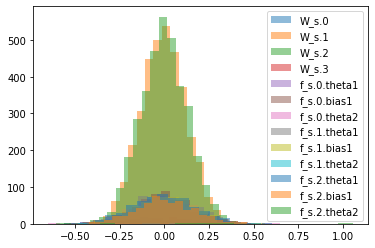

In [23]:
print('Net capacity:', get_capacity(network))
print('Parameters:')

for name, param in network.named_parameters():
    print(name, param.shape, 'requires_grad:', param.requires_grad)
#     plt.figure()
    W = to_numpy(param.data)
    plt.hist(W.flatten(),bins=20, alpha=0.5, label=f'{name}')
#     W /= np.linalg.norm(W, axis=1, keepdims=True)
#     print(W@W.T)
plt.legend()
plt.show()

In [24]:
X_s = network.forward(inpt_test_torch)
outpt_val_pred = to_numpy(X_s[-1])
outpt_val_pred.shape

(2, 1000)

In [25]:
for W in network.W_s:
    print(W.shape)

torch.Size([60, 3])
torch.Size([60, 60])
torch.Size([60, 60])
torch.Size([2, 60])


In [26]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(outpt_val_pred.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

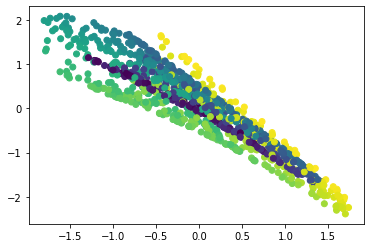

In [27]:
plt.scatter(outpt_val_pred[0], outpt_val_pred[1], c=color_test)
plt.show()

In [28]:
graph_constructor = ConstructUMAPGraph(metric='euclidean', 
                                        n_neighbors=20, 
                                        random_state=SEED)

# (epochs_per_sample, head, tail, weight) 
train_graph_data = graph_constructor(inpt_train)
test_graph_data = graph_constructor(inpt_test)

BATCH_SIZE_BP = 10000

dataset_train = UMAPDataset(inpt_train, *train_graph_data, device=device, batch_size=BATCH_SIZE_BP)
dataset_test = UMAPDataset(inpt_test, *test_graph_data, device=device, batch_size=BATCH_SIZE_BP)

# for hebbian update
train_hebb_dataloader = DataLoader(inpt_train_torch, batch_size=1, shuffle=True)

criterion_umap = UMAPLoss(device=device, 
                         min_dist=0.1,
                         negative_sample_rate=5,
                         edge_weight=None,
                         repulsion_strength=1.0)

criterion = umap_criterion_compatibility(criterion_umap)

Tue Jul 26 15:56:16 2022 Building RP forest with 10 trees
Tue Jul 26 15:56:16 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Tue Jul 26 15:56:34 2022 Building RP forest with 7 trees
Tue Jul 26 15:56:34 2022 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	Stopping threshold met -- exiting after 2 iterations


In [29]:
len(dataset_train), len(dataset_test)

(205, 25)

In [30]:
# for batch in dataset_test:
#     break

# X_s = network.forward(batch)
# batch.shape , criterion(X_s), X_s[-1].shape

In [31]:
# for batch in train_hebb_dataloader:
#     break

# X_s = network.forward(batch)
# batch.shape, X_s[-1].shape

### Hebbian learning parameters

In [32]:
# training_parameters = edict({'epochs':10,
#                            'enable_grad_train':False,
#                            'enable_grad_val':False,
#                            'backprop_learning':False,
#                            'hebbian_learning':True,
#                            'lr_bp':None,
#                            'wd_bp':None, 
#                            'maxiter':None, # maxiter
#                            'progress_bar':True,
#                            'weight_saver':None,
#                            'calculate_grad':False,
#                            'clip_grad_value': None,
#                            'val_metrics':None,
#                            'device':device
#                           })

# criterion_kwargs = defaultdict(dict)
# criterion_kwargs['skip_train'] = True
# criterion_kwargs['skip_val'] = False

# opt = None

### Backprop training parameters

In [33]:
training_parameters = edict({'epochs':200,
                           'enable_grad_train':True,
                           'enable_grad_val':True,
                           'backprop_learning':True,
                           'hebbian_learning':False,
                           'lr':1e-4,
                           'wd':0, 
                           'maxiter':1000, # maxiter
                           'progress_bar':True,
                           'weight_saver':None,
                           'calculate_grad':True,
                           'clip_grad_value': None,
                           'val_metrics':None,
                           'device':device
                          })

criterion_kwargs = defaultdict(dict)
criterion_kwargs['skip_train'] = False
criterion_kwargs['skip_val'] = False

opt = None
if training_parameters['backprop_learning']:
    opt = optim.Adam(get_grad_params(network.parameters()), 
                     lr=training_parameters.lr,  
                     weight_decay=training_parameters.wd)

In [34]:
for p in get_grad_params(network.parameters()):
    print(p.shape)

torch.Size([60, 3])
torch.Size([60, 60])
torch.Size([60, 60])
torch.Size([2, 60])
torch.Size([10, 60])
torch.Size([10, 60])
torch.Size([1, 10])
torch.Size([10, 60])
torch.Size([10, 60])
torch.Size([1, 10])
torch.Size([10, 60])
torch.Size([10, 60])
torch.Size([1, 10])


In [35]:
if opt is not None:
    print(len(opt.param_groups[0]['params']))

13


### BP training

In [36]:
metric_dict = None

network, opt, metric_dict = train(network, 
                                  opt=opt, 
                                  criterion=criterion,
                                  criterion_kwargs=criterion_kwargs,
                                  parameters=training_parameters,
                                  train_dataloader=dataset_train,
                                  val_dataloader=dataset_test, 
                                  metric_dict=metric_dict,
                                  val_metrics=None
                                  )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [08:56<00:00,  2.68s/it]


### Hebb training

In [37]:
# metric_dict = None

# network, opt, metric_dict = train(network, 
#                                   opt=None, 
#                                   criterion=criterion,
#                                   criterion_kwargs=criterion_kwargs,
#                                   parameters=training_parameters,
#                                   train_dataloader=train_hebb_dataloader,
#                                   val_dataloader=dataset_test, 
#                                   metric_dict=metric_dict,
#                                   val_metrics=None
#                                   )

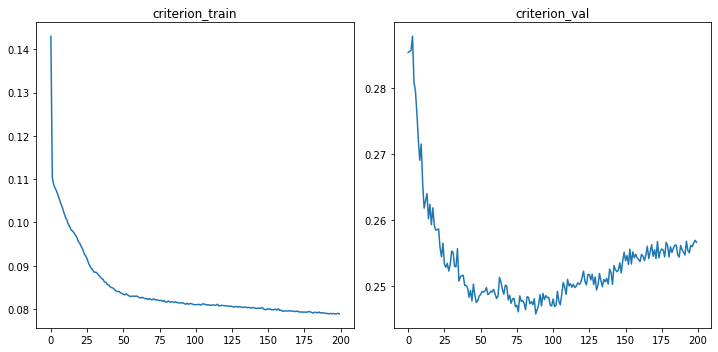

In [38]:
plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,4,1)
ax1.plot(metric_dict['criterion_train'])
ax1.set_title('criterion_train')

ax2 = plt.subplot(1,4,2)
ax2.plot(metric_dict['criterion_val'])
ax2.set_title('criterion_val')

plt.tight_layout()
plt.show()

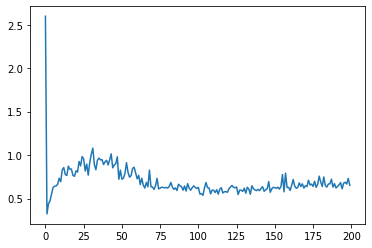

In [39]:
if 'grad_norm_train' in metric_dict:
    plt.plot(metric_dict['grad_norm_train'])

In [40]:
X_s_pred = network(inpt_test_torch.to(device))
# X_s_pred = network(inpt_train_torch.to(device))

outpt_val_pred = to_numpy(X_s_pred[-1])

In [41]:
# Q_loc_val_NET, Q_glob_val_NET = calculate_Q_metrics(inpt_test, outpt_val_pred.T)
# Q_loc_val_NET, Q_glob_val_NET

In [42]:
# plt.figure()
# plt.scatter(outpt_val_pred[0],
#             outpt_val_pred[1], 
#             c=color_test)
# plt.title(r'BP for $f_{\theta}$ only')
# plt.colorbar()
# plt.show()

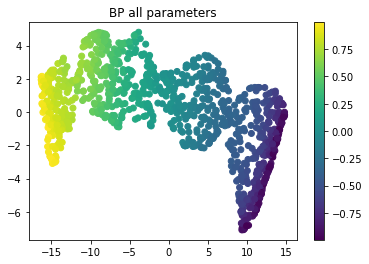

In [43]:
plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test)
plt.title(r'BP all parameters')
plt.colorbar()
plt.show()

In [44]:
# list(network.f_s[2].parameters())

In [45]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(X.T, columns=['x','y', 'z'])
# df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)
# fig.show()

min_dist=0.1,
negative_sample_rate=5,
edge_weight=None,
repulsion_strength=1.0

#### 3 layers, hidden dim  10
 - $f_{theta}$ only. $Q_l$ 0.52, $Q_g$: 0.75, loss ~ 0.15, still curved and overlapping embedding
 - $f_{theta}$ and $W$. $Q_l$ 0.78, $Q_g$: 0.7, loss ~ 0.07 - nicely flatten 

In [ ]:
# encoder_parameters = {
#                     'input_dim':inpt.shape[0],
#                     'hidden_dim':10,
#                     'embedding_dim':2,
#                     'add_readout':False,
#                     'add_recurrent_connections':False,
#                     'add_recurrent_nonlinearity':False,
#                     'hebbian_update':None,
#                     'inplace_update':False,
#                     'normalize_hebbian_update':False,
#                     'lr_hebb':None,
#                     'W_requires_grad':True,
#                     'W_r_requires_grad':False,
#                     'f_requires_grad':True,
#                     'final_nonlinearity':False,
#                     'parametrized_f':True,
#                     'nonlinearity': universal_approximator,
# #                     'nonlinearity': nn.Tanh(),
#                     'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
#                     'layers_number':3,
#                     'add_bn':True,
#                     'seed':None,
#                     'set_seed':False,
#                      }

# network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

In [48]:
# root_checkpoints = 'results/mlp_nonlinear/swiss_roll'
# hdim = encoder_parameters['hidden_dim']
# lnum = encoder_parameters['layers_number']
# Wgrad = int(encoder_parameters['W_requires_grad'])
# fgrad = int(encoder_parameters['f_requires_grad'])
# fname = encoder_parameters['nonlinearity'].__name__
# bn = int(encoder_parameters['add_bn'])
# hebb_train = training_parameters['hebbian_learning']
# hebb_train = 'hebb_' if hebb_train else ''
# bp_train = training_parameters['backprop_learning']
# bp_train = 'bp_' if bp_train else ''

# experiment_name = 'MLP_' + hebb_train + bp_train + f'hdim-{hdim}' + \
#                   f'_lnum-{lnum}' + f'_Wgrad-{Wgrad}' + f'_fgrad-{fgrad}' + f'_{fname}' + f'_bn-{bn}'

# checkpoint_name = os.path.join(root_checkpoints, experiment_name)
# torch.save(network.state_dict(), checkpoint_name)

In [47]:
# n_fs = len(network.f_s)
# ξ = torch.linspace(-5,5,1000).to(device)

# for layer in range(n_fs):
#     f_theta = network.f_s[layer]
#     if network.final_nonlinearity or layer < n_fs-1:
#         n_neurons = f_theta.input_dim
#         y = torch.stack([ξ for _ in range(n_neurons)],0) # [n_neurons, T]

#         f = to_numpy(f_theta(y)) # [n_neurons, T]

#         fig, axes = plt.subplots(ncols=n_neurons, nrows=1, figsize=(n_neurons*3,3))

#         for j,ax in enumerate(axes):
#             ax.plot(to_numpy(ξ), f[j])
#             ax.set_title(f'Neuron: {j}')

#         fig.suptitle(f'Layer: {layer}', y=1.1, color='blue')
    
# plt.tight_layout()
# plt.show()

In [48]:
# plt.ioff()# Meta-learning
# plt.figure()
# df = pd.DataFrame(outpt_val_pred.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

In [49]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(np.concatenate([inpt_test, outpt_val_pred], axis=1).T, columns=['x','y', 'z'])

# df['target'] = np.concatenate([np.zeros((inpt.shape[1])), 
#                                np.ones((inpt_test.shape[1]))])

# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')

# fig.show()